In [1]:
import pandas as pd
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score

import eli5

C:\Users\alfiy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [2]:
df = pd.read_csv('../Tech Stack/datasets/data.csv')

In [3]:
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [4]:
df.shape

(5842, 2)

In [5]:

import matplotlib.pyplot as plt

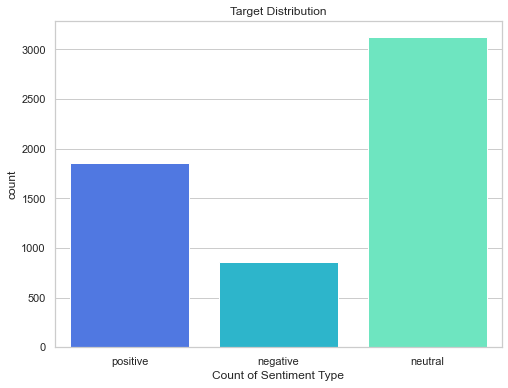

<Figure size 432x288 with 0 Axes>

In [6]:
sns.set_theme(style="whitegrid")
sns.set_palette('rainbow')
plt.figure(figsize=(8,6))
sns.countplot(x=df['Sentiment'])
plt.xlabel('Count of Sentiment Type')
plt.title('Target Distribution')
plt.show()
plt.savefig('Target Distribution')

In [7]:
import textstat

df['Sentence Length'] = df['Sentence'].apply(lambda x : textstat.lexicon_count(x, removepunct=True))

df_positive = df.loc[df['Sentiment'] == 'positive']
df_negative = df.loc[df['Sentiment'] == 'negative']
df_neutral = df.loc[df['Sentiment'] == 'neutral']


fig = make_subplots(rows=1, cols=3)

fig.append_trace(
    go.Box(name='Positive', y=df_positive['Sentence Length']),
    row=1, col=1
)

fig.append_trace(
    go.Box(name='Negative', y=df_negative['Sentence Length']),
    row=1, col=2
)

fig.append_trace(
    go.Box(name='Neutral', y=df_neutral['Sentence Length']),
    row=1, col=3
)

fig.update_layout(height=500, width=700, title_text="Distribution of Sentence Length across classes")
fig.show()

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


False

In [12]:
from rake_nltk import Rake
r = Rake()
negative_corpus = df_negative['Sentence'].tolist()
negative_corpus = " ".join(negative_corpus)
r.extract_keywords_from_text(negative_corpus)
top_phrases_neg = r.get_ranked_phrases()[0:100]


positive_corpus = df_positive['Sentence'].tolist()
positive_corpus = " ".join(positive_corpus)
r.extract_keywords_from_text(positive_corpus)
top_phrases_pos = r.get_ranked_phrases()[0:100]


neutral_corpus = df_neutral['Sentence'].tolist()
neutral_corpus = " ".join(neutral_corpus)
r.extract_keywords_from_text(neutral_corpus)
top_phrases_neutral = r.get_ranked_phrases()[0:100]

pd.DataFrame({'Top Negative Phrases':top_phrases_neg,'Top Positive Phrases':top_phrases_pos,'Top Neutral Phrases':top_phrases_neutral})


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\alfiy/nltk_data'
    - 'C:\\Users\\alfiy\\anaconda3\\nltk_data'
    - 'C:\\Users\\alfiy\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\alfiy\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\alfiy\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [9]:
import spacy
nlp = spacy.load('en_core_web_lg')
def ner_counter(doc):
    gpe_count = 0
    org_count = 0
    person_count = 0
    money_count=0
    for tok in doc.ents:
        if tok.label_ == "GPE":
            gpe_count = gpe_count + 1
        elif tok.label_ == "ORG":
            org_count=org_count+1
        elif tok.label_ == "PERSON":
            person_count=person_count+1
        elif tok.label_ == "MONEY":
            money_count=money_count+1
    return (gpe_count,org_count,person_count,money_count)

sentences = df['Sentence'].tolist()
sentences = " ".join(sentences)
sentences = nlp(sentences)
entity_counts = list(ner_counter(sentences))
entity_df = {'Entity Type':['GPE', 'ORG', 'PERSON', 'MONEY'],
        'Count':entity_counts}
fig = px.bar(entity_df,x='Entity Type',y='Count',color='Entity Type',text_auto=True)
fig.update_layout(height=500,width=500)


OSError: [E050] Can't find model 'en_core_web_lg'. It doesn't seem to be a Python package or a valid path to a data directory.

In [32]:
import en_core_web_lg

ModuleNotFoundError: No module named 'en_core_web_lg'

In [ ]:
# import stylecloud
from IPython.display import Image
sentences = df['Sentence'].tolist()
corpus = " ".join(sentences)
stylecloud.gen_stylecloud(corpus,
                          icon_name = 'fas fa-globe',
                          palette='colorbrewer.diverging.Spectral_11',
                          background_color='white',gradient='vertical',stopwords=True
                          )


Image(filename='stylecloud.png') 

In [10]:
df_neutral = df[(df['Sentiment']=='neutral')] 
df_negative = df[(df['Sentiment']=='negative')]
df_positive = df[(df['Sentiment']=='positive')]


# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples= 2000, 
                                 random_state=42)  

df_positive_upsampled = resample(df_positive, 
                                 replace=True,    
                                 n_samples= 2000, 
                                 random_state=42)  


# Concatenate the upsampled dataframes with the neutral dataframe
df_upsampled = pd.concat([df_negative_upsampled,df_neutral,df_positive_upsampled])

In [11]:
df_upsampled.columns

Index(['Sentence', 'Sentiment', 'Sentence Length'], dtype='object')

In [12]:
dataColumn = df_upsampled.columns[0]
labelColumn = df_upsampled.columns[1]

In [13]:
labelColumn

'Sentiment'

In [14]:
df_upsampled[0:5]

,Sentence,Sentiment,Sentence Length
742,"The currency effect had a 3.0 pct , or 20 mln ...",negative,18
3015,$MFLX up pre mkt. Looks like GAP has been fil...,negative,14
1898,"However , the growth margin slowed down due to...",negative,11
777,It's a bad idea to make 5 min predictions base...,negative,29
472,"Key price to watch in $NFLX, off the previous ...",negative,14


In [15]:
import numpy as np 
# import pandas as pd
import re
import string
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

In [16]:
dataset_copy = df_upsampled.copy()

dataset = dataset_copy.sample(frac=0.80, random_state=0)
val_dataset = dataset_copy.drop(dataset.index)

In [17]:
model_path = '..\Tech Stack\models\distilroberta-finetuned-financial-news-sentiment-analysis'

In [18]:
# Function to remove hashtags....etc. Intended to improve performance   
def pre_process(dataset):
    # Lowercase
    dataset[dataColumn] = dataset[dataColumn].apply(lambda x: x.lower())
    # Convert labels to numbers
    labelDict = {'negative': 0, 'neutral': 1, 'positive': 2 }
    dataset[labelColumn] = dataset[labelColumn].apply(lambda x: labelDict[x])
    # Remove hashtag
    # dataset[dataColumn] = dataset['text'].apply(lambda x: x.replace('#', ' ')) 
    # Remove websites
    #dataset[dataColumn] = dataset[dataColumn].apply(lambda x: re.sub(r"http\S+", " ", x))
    # Remove emails
    #dataset[dataColumn] = dataset[dataColumn].apply(lambda x: re.sub(r"\S*@\S*\s?", " ", x))
    # Remove punctuation
    dataset[dataColumn] = dataset[dataColumn].apply(lambda x: re.sub(r"[^a-zA-Z0-9]", " ", x))
    # Remove 'RT'
    #dataset[dataColumn] = dataset[dataColumn].apply(lambda x: re.sub(r"RT\s+", " ", x)) 
    print(dataset[0:4])
    return dataset


In [19]:
dataset = pre_process(dataset)
val_dataset = pre_process(val_dataset)

                                               Sentence  Sentiment  \
4860  3 star analyst joe wittine from longbow resear...          2   
4857  cash flow from operations in january december ...          1   
44    a portion     12 5 million   will be recorded ...          2   
3065  operating profit   excluding non recurring ite...          1   

      Sentence Length  
4860               13  
4857               24  
44                 23  
3065               14  
                                               Sentence  Sentiment  \
1220      bhp billiton posts big loss  slashes dividend          0   
1442   yelp wayyy overvalued right now imo  should b...          0   
948   the announcement pushed freenet shares down 6 ...          0   
2624    vivus  vvus bear raid in effect  stock down 12           0   

      Sentence Length  
1220                7  
1442               22  
948                35  
2624                9  


C:\Users\alfiy\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alfiy\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alfiy\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [21]:
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("Operating profit totaled EUR 9.4 mn , down from EUR 11.7 mn in 2004!")

[{'label': 'negative', 'score': 0.9987825751304626}]

In [23]:
sentiment_task("I am so happy!")

[{'label': 'positive', 'score': 0.9955506324768066}]

In [24]:
sentiment_task("I am so sad!")

[{'label': 'negative', 'score': 0.8023840188980103}]

In [28]:
x = sentiment_task("I am so sad!")

In [31]:
x[0]['label']

'negative'

In [25]:
val_dataset

,Sentence,Sentiment,Sentence Length
1220,bhp billiton posts big loss slashes dividend,0,7
1442,yelp wayyy overvalued right now imo should b...,0,22
948,the announcement pushed freenet shares down 6 ...,0,35
2624,vivus vvus bear raid in effect stock down 12,0,9
5082,operating profit decreased to nearly eur 1 7 m...,0,9
...,...,...,...
3016,finnish forest machinery manufacturer ponsse h...,2,17
4412,metrics in qpr scorecard now support date te...,2,23
1754,1 block lamp harri koskinen s light was intro...,2,18
4786,added long at friday close spy labu blue ...,2,9


In [36]:
predictedColumn = 'Predicted Sentiment'

In [32]:
def predict(dataset):
    labelDict = {'negative': 0, 'neutral': 1, 'positive': 2 }
    dataset[predictedColumn] = dataset[dataColumn].apply(lambda x: labelDict[sentiment_task(x)[0]['label']])
    return dataset

In [33]:
val_dataset = predict(val_dataset)

C:\Users\alfiy\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
val_dataset

,Sentence,Sentiment,Sentence Length,Predicted Sentiment
1220,bhp billiton posts big loss slashes dividend,0,7,0
1442,yelp wayyy overvalued right now imo should b...,0,22,0
948,the announcement pushed freenet shares down 6 ...,0,35,0
2624,vivus vvus bear raid in effect stock down 12,0,9,0
5082,operating profit decreased to nearly eur 1 7 m...,0,9,0
...,...,...,...,...
3016,finnish forest machinery manufacturer ponsse h...,2,17,2
4412,metrics in qpr scorecard now support date te...,2,23,2
1754,1 block lamp harri koskinen s light was intro...,2,18,1
4786,added long at friday close spy labu blue ...,2,9,1


In [37]:
y_true = val_dataset[labelColumn]
y_pred = val_dataset[predictedColumn]
accuracy_score(y_true, y_pred)

0.7825567502986858

In [42]:
model_path = '..\Tech Stack\models\\twitter-roberta-base-sentiment-latest'

In [43]:
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("Operating profit totaled EUR 9.4 mn , down from EUR 11.7 mn in 2004!")

Some weights of the model checkpoint at ..\Tech Stack\models\twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'neutral', 'score': 0.7783729434013367}]

In [44]:
sentiment_task("I am so happy!")

[{'label': 'positive', 'score': 0.9847161769866943}]

In [45]:
sentiment_task("I am so sad!")

[{'label': 'negative', 'score': 0.8957254886627197}]

In [46]:
sentiment_task("I like you")

[{'label': 'positive', 'score': 0.6540073156356812}]

In [50]:
predictedColumn = 'Twitter Roberta Predicted Sentiment'

In [51]:
def predict(dataset):
    labelDict = {'negative': 0, 'neutral': 1, 'positive': 2 }
    dataset[predictedColumn] = dataset[dataColumn].apply(lambda x: labelDict[sentiment_task(x)[0]['label']])
    return dataset

In [52]:
val_dataset = predict(val_dataset)
y_true = val_dataset[labelColumn]
y_pred = val_dataset[predictedColumn]
accuracy_score(y_true, y_pred)

C:\Users\alfiy\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.7586618876941458

In [53]:
val_dataset

,Sentence,Sentiment,Sentence Length,Predicted Sentiment,Twitter Predicted Sentiment
1220,bhp billiton posts big loss slashes dividend,0,7,0,0
1442,yelp wayyy overvalued right now imo should b...,0,22,1,1
948,the announcement pushed freenet shares down 6 ...,0,35,0,0
2624,vivus vvus bear raid in effect stock down 12,0,9,1,1
5082,operating profit decreased to nearly eur 1 7 m...,0,9,1,1
...,...,...,...,...,...
3016,finnish forest machinery manufacturer ponsse h...,2,17,1,1
4412,metrics in qpr scorecard now support date te...,2,23,2,2
1754,1 block lamp harri koskinen s light was intro...,2,18,2,2
4786,added long at friday close spy labu blue ...,2,9,1,1
